In [1]:
import cuml
import cudf
import os
import time

In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from cuml import DBSCAN as cumlDBSCAN
from cuml.cluster import KMeans as cuKMeans
from cuml.decomposition import PCA
import cupy

In [4]:
!python --version

Python 3.7.10


In [5]:
!pwd

/rapids/notebooks/host


In [6]:
data_dir='/rapids/notebooks/host/QA_attentions_pickled'

In [7]:
df = cudf.read_csv(os.path.join(data_dir,'representation_df.csv'))

In [82]:
df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 288000 entries, 0 to 287999
Columns: 2049 entries, Unnamed: 0 to 2047
dtypes: float64(2048), int64(1)
memory usage: 4.4 GB


In [8]:
## From running HDBSCAN on CPU on 14400 samples
# start_time = time.time()
# clusterer2 = hdbscan.HDBSCAN(
#     metric="manhattan",
#     min_cluster_size=40,
#     min_samples = 20,
#     core_dist_n_jobs=16)
# clusterer2.fit(df_b)
# print("--- %s seconds ---" % (time.time() - start_time))
##--- 729.1382730007172 seconds ---

In [11]:
df_small = df[0:14400]

In [14]:
df_small.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 14400 entries, 0 to 14399
Columns: 2049 entries, Unnamed: 0 to 2047
dtypes: float64(2048), int64(1)
memory usage: 225.1 MB


In [7]:
cuml_dbscan = cumlDBSCAN( eps = 0.000001,
                          metric='euclidean', #default - no manhattan here?
                          min_samples = 5)

In [78]:
start_time = time.time()
trained_DBSCAN = cuml_dbscan.fit(df_small)
print("--- %s seconds ---" % (time.time() - start_time))

--- 4.435322523117065 seconds ---


In [79]:
# wut. LOL

/opt/conda/envs/rapids/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

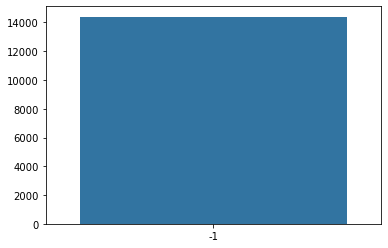

In [80]:
df_labels = pd.DataFrame(trained_DBSCAN.labels_.to_pandas())
rating_count = df_labels[0].value_counts()

x = rating_count.index
y = rating_count.values

sns.barplot(x, y)

In [66]:
n_clusters = 80
random_state = 0

In [67]:
%%time
kmeans_cuml = cuKMeans(init="k-means||",
                       n_clusters=n_clusters,
                       oversampling_factor=400,
                       random_state=random_state)

trained_kmeans = kmeans_cuml.fit(df_small)

CPU times: user 22.6 s, sys: 0 ns, total: 22.6 s
Wall time: 21.8 s


/opt/conda/envs/rapids/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

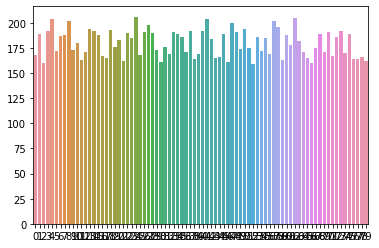

In [68]:
df_labels = pd.DataFrame(trained_kmeans.labels_.to_pandas())
rating_count = df_labels[0].value_counts()

x = rating_count.index
y = rating_count.values

sns.barplot(x, y)

In [84]:
n_clusters = 30
random_state = 0

%%time
kmeans_cuml = cuKMeans(init="k-means||",
                       n_clusters=n_clusters,
                       oversampling_factor=400,
                       random_state=random_state)

trained_kmeans = kmeans_cuml.fit(df)

CPU times: user 15min 3s, sys: 6.73 ms, total: 15min 3s
Wall time: 14min 57s


/opt/conda/envs/rapids/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

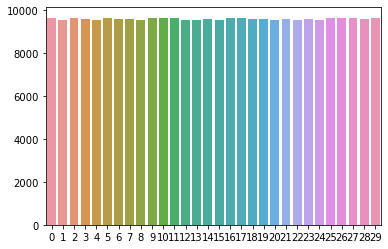

In [85]:
df_labels = pd.DataFrame(trained_kmeans.labels_.to_pandas())
rating_count = df_labels[0].value_counts()

x = rating_count.index
y = rating_count.values

sns.barplot(x, y)

In [89]:
pca_float = PCA(n_components = 2)
pca_float.fit(df)

PCA()

In [90]:
print(f'components: {pca_float.components_}')
print(f'explained variance: {pca_float.explained_variance_}')
exp_var = pca_float.explained_variance_ratio_
print(f'explained variance ratio: {exp_var}')

print(f'singular values: {pca_float.singular_values_}')
print(f'mean: {pca_float.mean_}')
print(f'noise variance: {pca_float.noise_variance_}')

trans_gdf_float = pca_float.transform(df)
print(f'Inverse: {trans_gdf_float}')

input_gdf_float = pca_float.inverse_transform(trans_gdf_float)
print(f'Input: {input_gdf_float}')

components:            0             1             2             3             4     \
0 -1.000000e+00  7.987097e-09  1.300720e-08 -3.318241e-09  1.169171e-08   
1  7.042852e-07  1.527258e-02  1.909899e-02  4.310537e-05  1.445623e-02   

           5             6             7             8             9     ...  \
0  1.761976e-08  5.577395e-09  8.295878e-09  3.910529e-08  4.433001e-09  ...   
1  7.219042e-03  5.894176e-03  6.222899e-03  6.369957e-02  6.303537e-03  ...   

           2039          2040          2041          2042          2043  \
0  7.595453e-09  1.319307e-08  8.931765e-09  3.846817e-08  2.232395e-08   
1 -2.504062e-03  2.086796e-02  1.032663e-02  5.535971e-02  3.293147e-02   

           2044          2045          2046          2047          2048  
0  1.794644e-08  6.768712e-09  1.571451e-08  4.038068e-09 -1.691690e-09  
1  2.436508e-02  1.189893e-02  2.199973e-02  8.816845e-03  5.586183e-03  

[2 rows x 2049 columns]
explained variance: 0    6.912024e+09
1    1.120

In [92]:
%%time
n_clusters = 30
random_state = 0

kmeans_cuml = cuKMeans(init="k-means||",
                       n_clusters=n_clusters,
                       oversampling_factor=400,
                       random_state=random_state)

trained_kmeans = kmeans_cuml.fit(trans_gdf_float)

CPU times: user 11.1 s, sys: 0 ns, total: 11.1 s
Wall time: 11 s


/opt/conda/envs/rapids/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

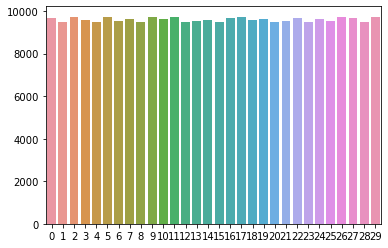

In [93]:
df_labels = pd.DataFrame(trained_kmeans.labels_.to_pandas())
rating_count = df_labels[0].value_counts()

x = rating_count.index
y = rating_count.values

sns.barplot(x, y)

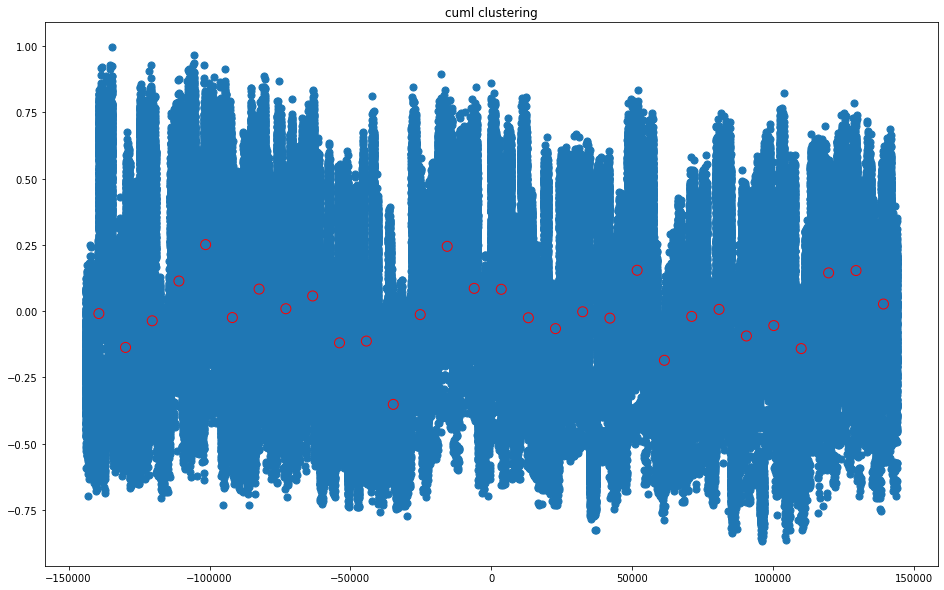

In [109]:
fig = plt.figure(figsize=(16, 10))
host_data = trans_gdf_float.to_pandas()
plt.scatter(host_data.iloc[:, 0], host_data.iloc[:, 1], s=50, cmap='viridis')

#plot the cuml kmeans centers with red circle outlines
centers_cuml = kmeans_cuml.cluster_centers_
plt.scatter(cupy.asnumpy(centers_cuml[0].values), 
            cupy.asnumpy(centers_cuml[1].values), 
            facecolors = 'none', edgecolors='red', s=100)

plt.title('cuml clustering')

plt.show()

In [5]:
data_dir='/rapids/notebooks/host/'

In [6]:
df = cudf.read_csv(os.path.join(data_dir,'representation_df_10000.csv'), nrows=500000)

In [9]:
cuml_dbscan = cumlDBSCAN( eps = 1,
                          metric='euclidean', #default - no manhattan here?
                          min_samples = 5)

In [10]:
start_time = time.time()
trained_DBSCAN = cuml_dbscan.fit(df)
print("--- %s seconds ---" % (time.time() - start_time))

[W] [02:53:11.719277] Batch size limited by the chosen integer type (4 bytes). 4862 -> 4294. Using the larger integer type might result in better performance
--- 7197.254801273346 seconds ---


/opt/conda/envs/rapids/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

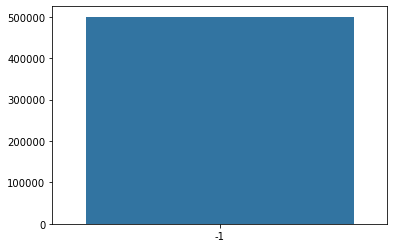

In [11]:
df_labels = pd.DataFrame(trained_DBSCAN.labels_.to_pandas())
rating_count = df_labels[0].value_counts()

x = rating_count.index
y = rating_count.values

sns.barplot(x, y)

In [10]:
sm = df[:100000]

In [11]:
sm = sm.iloc[:,1:]

In [15]:
%%time
cuml_dbscan = cumlDBSCAN( eps = 0.5,
                          metric='euclidean', #default - no manhattan here?
                          min_samples = 10,
                          max_mbytes_per_batch = 10000
                        )

start_time = time.time()
trained_DBSCAN = cuml_dbscan.fit(sm)
print("--- %s seconds ---" % (time.time() - start_time))

labels = trained_DBSCAN.labels_.values_host

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

# df_labels = pd.DataFrame(trained_DBSCAN.labels_.to_pandas())
# rating_count = df_labels[0].value_counts()

# x = rating_count.index
# y = rating_count.values

# sns.barplot(x, y)

--- 255.17437767982483 seconds ---
Estimated number of clusters: 14
Estimated number of noise points: 97590
CPU times: user 4min 15s, sys: 236 ms, total: 4min 15s
Wall time: 4min 15s


/opt/conda/envs/rapids/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

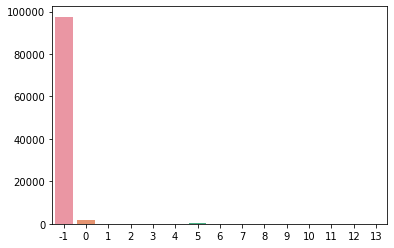

In [17]:
df_labels = pd.DataFrame(trained_DBSCAN.labels_.to_pandas())
rating_count = df_labels[0].value_counts()

x = rating_count.index
y = rating_count.values

sns.barplot(x, y)

In [40]:
rating_count

-1     97590
 0      1869
 5       218
 1        82
 4        75
 3        38
 6        31
 10       15
 9        14
 11       14
 2        12
 13       12
 7        10
 8        10
 12       10
Name: 0, dtype: int64

In [21]:
from cuml.neighbors import NearestNeighbors

In [24]:
import numpy as np

In [29]:
plt.figure(figsize=(10,5))
nn = NearestNeighbors(n_neighbors=5).fit(sm)
distances, idx = nn.kneighbors(sm)
distances = distances.values


<Figure size 720x360 with 0 Axes>

In [36]:
distances = cupy.asnumpy(distances)

In [38]:
distances[:10]

array([[0.        , 0.29186642, 0.77420497, 0.8226489 , 0.82618546],
       [0.00138107, 0.34081823, 0.7350986 , 0.8109363 , 0.81589735],
       [0.00352105, 0.24164744, 0.7432032 , 0.7448522 , 0.74507016],
       [0.00195312, 0.1845393 , 0.6967942 , 0.7010052 , 0.7132925 ],
       [0.00195312, 0.3866059 , 0.7982116 , 0.8248956 , 0.8423875 ],
       [0.        , 0.4345396 , 0.7860506 , 0.8078775 , 0.8130605 ],
       [0.        , 0.38028616, 0.8245126 , 0.84708846, 0.8518267 ],
       [0.00195312, 0.45699108, 0.79223686, 0.8058223 , 0.8072274 ],
       [0.00138107, 0.19984964, 0.7352251 , 0.74168104, 0.7434059 ],
       [0.        , 0.50276184, 0.82692355, 0.8535136 , 0.86132836]],
      dtype=float32)

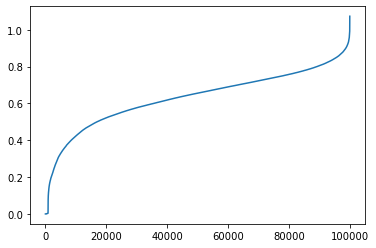

In [39]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.show()

In [42]:
%%time
cuml_dbscan = cumlDBSCAN( eps = 0.75,
                          metric='euclidean', #default - no manhattan here?
                          min_samples = 10,
                          max_mbytes_per_batch = 10000
                        )

start_time = time.time()
trained_DBSCAN = cuml_dbscan.fit(sm)
print("--- %s seconds ---" % (time.time() - start_time))

labels = trained_DBSCAN.labels_.values_host

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)



--- 255.34441256523132 seconds ---
Estimated number of clusters: 55
Estimated number of noise points: 36019
CPU times: user 4min 15s, sys: 256 ms, total: 4min 15s
Wall time: 4min 15s


/opt/conda/envs/rapids/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

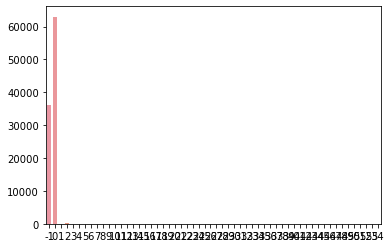

In [44]:
df_labels = pd.DataFrame(trained_DBSCAN.labels_.to_pandas())
rating_count = df_labels[0].value_counts()

x = rating_count.index
y = rating_count.values

sns.barplot(x, y)

In [45]:
rating_count

 0     62977
-1     36019
 2       352
 11       50
 5        35
 1        22
 3        22
 35       21
 18       19
 23       16
 20       16
 21       15
 22       14
 19       14
 24       13
 39       12
 41       12
 33       12
 38       12
 42       12
 10       12
 4        12
 27       11
 44       11
 25       11
 28       11
 26       10
 37       10
 54       10
 51       10
 50       10
 49       10
 47       10
 45       10
 43       10
 17       10
 12       10
 8        10
 36       10
 15       10
 13       10
 30       10
 34       10
 31       10
 9         9
 32        9
 40        9
 14        8
 7         8
 29        8
 6         7
 16        7
 46        6
 48        6
 52        6
 53        4
Name: 0, dtype: int64

In [7]:
med = df[:400000]

In [8]:
med = med.iloc[:,1:]

In [9]:
%%time
cuml_dbscan = cumlDBSCAN( eps = 0.75,
                          metric='euclidean', #default - no manhattan here?
                          min_samples = 10,
                          max_mbytes_per_batch = 10000
                        )

start_time = time.time()
trained_DBSCAN = cuml_dbscan.fit(med)
print("--- %s seconds ---" % (time.time() - start_time))

labels = trained_DBSCAN.labels_.values_host

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)



--- 4578.115650892258 seconds ---
Estimated number of clusters: 69
Estimated number of noise points: 105521
CPU times: user 1h 16min 21s, sys: 2.47 s, total: 1h 16min 23s
Wall time: 1h 16min 18s


/opt/conda/envs/rapids/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

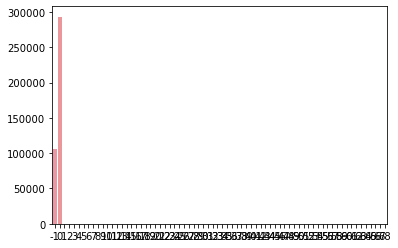

In [13]:
df_labels = pd.DataFrame(trained_DBSCAN.labels_.to_pandas())
label_count = df_labels[0].value_counts()

x = label_count.index
y = label_count.values

sns.barplot(x, y)

In [14]:
rating_count

 0     293241
-1     105521
 2        198
 4         46
 10        42
        ...  
 67         8
 9          7
 56         7
 43         7
 57         5
Name: 0, Length: 70, dtype: int64

In [15]:
rating_count[:20]

 0     293241
-1     105521
 2        198
 4         46
 10        42
 1         40
 6         40
 60        37
 26        33
 25        33
 51        30
 15        30
 5         28
 14        26
 46        24
 7         23
 13        21
 45        21
 8         19
 53        19
Name: 0, dtype: int64